In [62]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
import boto3 
import s3fs
import json
import datetime
from tzlocal import get_localzone as tzlocal
import numpy as np

In [ ]:
!conda install tzlocal s3fs tqdm -n fcp -y

In [63]:
import datetime
from tzlocal import get_localzone as tzlocal
import boto3
from tqdm import tqdm_notebook as tqdm

bucket_name = 'fog-bigdata-bmw-data'
s3_con = boto3.client('s3')
obj_list = s3_con.list_objects(Bucket=bucket_name,Prefix='metrics2/output')['Contents']
file_names = [key['Key'] for key in obj_list]

data = []
for file_name in tqdm(file_names):
    if not file_name.endswith('output.json'):
        continue
    file_str = s3_con.get_object(Bucket=bucket_name, Key=file_name).get('Body').read().decode('utf-8')
    batch = eval(file_str)
    if 'response-code-200' in batch.keys():
        data = data + batch['response-code-200']['Datapoints']

In [64]:
df = pd.DataFrame(data)
df.index = [i.replace(tzinfo=None) for i in pd.to_datetime(df.Timestamp)]
df = df.drop(columns=['Unit'])
df = df.groupby('Timestamp').max()
series = pd.Series(data=df.SampleCount.values, index=[i.replace(tzinfo=None) for i in pd.to_datetime(df.index)])
series = series.sort_index()
data_freq = '5min'
series = series.groupby([pd.Grouper(freq=data_freq)]).sum()

# Apply a running mean to the last 15 minutes at each value
n_backsteps = 5
conv = np.hstack([np.ones(n_backsteps)/n_backsteps,np.zeros(n_backsteps-1)])
pad_vals = np.pad(series.values,n_backsteps-1,mode='edge')
series = pd.Series(data=np.convolve(pad_vals,conv,mode='valid'),index=series.index)

# Create feature series of holidays
end_of_holiday = datetime.date(2019, 1, 7)
holidays_data = [1 if time < pd.Timestamp(end_of_holiday,tz=None) else 0  for time in series.index]
holidays_feature_serie = pd.Series(data=holidays_data, index=series.index)

weekends_date = [0 if time.weekday() < 5 else 1 for time in series.index]
weekends_feature_series = pd.Series(data=weekends_date, index=series.index)

In [65]:
# For some reason the data is scaled up in this timespan
# So we clean it manually
series[np.logical_and(series.index >= pd.Timestamp(2019,1,26),series.index < pd.Timestamp(2019,1,31,8,55))] /= 2

Text(0, 0.5, 'Number of samples')

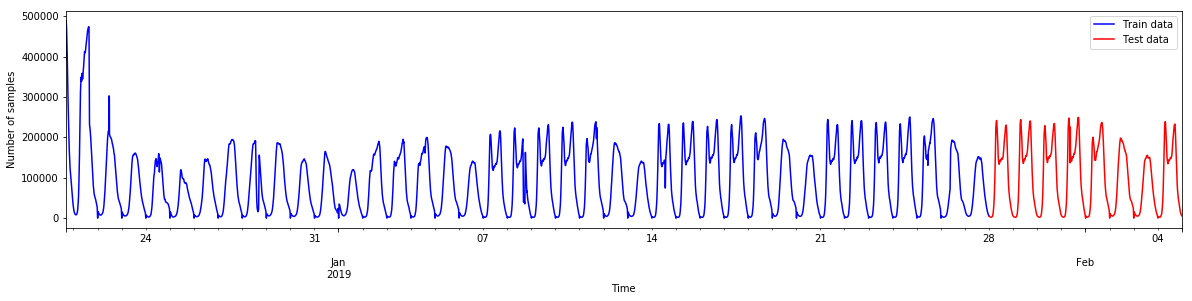

In [66]:
test_idx = (series.index > datetime.datetime(2019,1,28,0,0,0))
train_idx = np.logical_not(test_idx)
ax = series[train_idx].plot(
    figsize=(20,4),
    color='b',
    label='Train data'
)
series[test_idx].plot(
    color='r',
    label='Test data',
    ax = ax
)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set_xlabel('Time')
ax.set_ylabel('Number of samples')

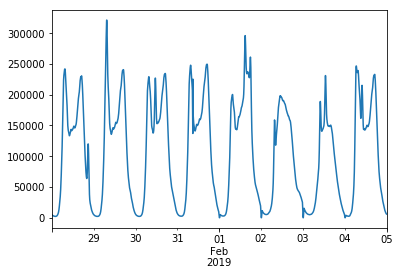

In [159]:
test = series[test_idx].copy()
outliers = np.zeros(len(test.index))
outlier_idx = np.random.randint(0,len(outliers),10)
outliers[outlier_idx] = np.random.rand() * 0.5 + 0.5
outliers = pd.Series(outliers).rolling(window=100,win_type='gaussian').mean(std=4)
outliers[np.isnan(outliers.values)]=0

# test[test.index[outlier_idx]] = outliers * 100000
# test.plot()
# test = test + outliers
# test
test = pd.Series(index=test.index,data=(test.values + outliers.values * 1e6))

In [165]:
pd.Series(test.index[outlier_idx]).to_csv('outliers.csv')

/Users/marius/anaconda3/envs/fcp/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [49]:
sns.timeseries

<module 'seaborn.timeseries' from '/Users/marius/anaconda3/envs/fcp/lib/python3.7/site-packages/seaborn/timeseries.py'>

# Upload preprocessed data for random cut forest


In [160]:

from os import path 

data_bucket_name = 'fog-datasets'
prefix = 'rcf'

s3_data_path = "{}/{}/data".format(data_bucket_name, prefix)

s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/data.csv", 'w') as fp:
    fp.write(series[train_idx].to_csv())

with s3filesystem.open(s3_data_path + "/test/data_with_outliers.csv", 'w') as fp:
    fp.write(test.to_csv())

/Users/marius/anaconda3/envs/fcp/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if sys.path[0] == '':
/Users/marius/anaconda3/envs/fcp/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  from ipykernel import kernelapp as app


[-2.  0.  2.  4.  6.  8. 10.]


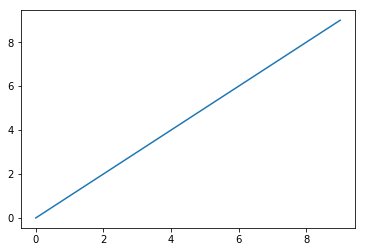

In [31]:
ax = plt.gca()
ax.plot(np.arange(10))
print(ax.get_xticks())

# Upload preprocessed data for DeepAR

In [161]:
import json
from deep_ar import series_to_jsonline

# Upload preprocessed data for deep AR
data_bucket_name = 'fog-datasets'
prefix = 'deep_ar'
s3_data_path = "{}/{}/data".format(data_bucket_name, prefix)

with s3filesystem.open(s3_data_path + "/train/data.json", 'w') as fp:
    fp.write(series_to_jsonline(series[train_idx]))

with s3filesystem.open(s3_data_path + "/test/data_with_outliers.json", 'w') as fp:
    fp.write(series_to_jsonline(test, [list(holidays_feature_serie[test_idx]), list(weekends_feature_series[test_idx])]))



In [ ]:
import os

image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')
role = 'arn:aws:iam::746022503515:role/sage_maker'
data_bucket_name = 'fog-datasets'
prefix = 'deep_ar'
s3_output_path = "{}/{}/output".format(data_bucket_name, prefix)

train_locally = False

train_instance_type = 'local' if train_locally else 'ml.c4.xlarge'

if train_locally:
    print('Training locally...')

sagemaker_session = sagemaker.Session()

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type=train_instance_type,
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

n_daily_datapoints = (60*24)//5

hyperparameters = dict(
    time_freq=data_freq,
    context_length=str(n_daily_datapoints),
    prediction_length=str(n_daily_datapoints),
    num_cells="40",
    num_layers="3",
    likelihood="gaussian",
    epochs="20",
    mini_batch_size="32",
    learning_rate="0.001",
    dropout_rate="0.05",
    early_stopping_patience="10"
)

estimator.set_hyperparameters(**hyperparameters)

data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

In [ ]:
# Create endpoint
from deep_ar import DeepARPredictor

job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

In [ ]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)



In [ ]:

predictor.set_prediction_parameters(freq=data_freq, prediction_length=n_3h_datapoints)
predictions = predictor.predict([series[-45:-42]], 
                                [[list(holidays_feature_serie[-3:])+[0 for i in range(n_3h_datapoints)],
                                    list(weekends_feature_series[-3:])+[0 for i in range(n_3h_datapoints)]]
                                ])


for k in range(len(predictions)):
    plt.figure(figsize=(12,6))
    series[test_idx].plot(label='target')
    p10 = predictions[k]['0.1']
    p90 = predictions[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    predictions[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()



# Select two weeks of working days to mock data streaming

In [ ]:
df.index = [i.replace(tzinfo=None) for i in df.index]
s_df = df[df.index>=pd.to_datetime('2019-01-07')]
s_df = s_df[s_df.index<pd.to_datetime('2019-01-21')]
s_df.plot()

predictor.set_prediction_parameters(data_freq, n_daily_datapoints * 7)

In [ ]:
predictions = pd.DataFrame(predictor.predict([series[train_idx]])[0])

In [ ]:
ax = series[train_idx].plot(
    figsize=(20,10),
    color='b',
    label='Train data'
)
series[test_idx].plot(
    figsize=(20,10),
    color='r',
    label='Test data (Ground truth)',
    ax = ax
)
predictions.plot(
    figsize=(20,10),
    color='green',
    label='Predictions',
    ax = ax
)